In [3]:
%pip install wget

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9680 sha256=41b6e7536dc23139b1c6a28a4459d64e7f4e8e64062c289aab09802ca32fd2a2
  Stored in directory: c:\users\alden\appdata\local\pip\cache\wheels\01\46\3b\e29ffbe4ebe614ff224bad40fc6a5773a67a163251585a13a9
Successfully built wget
Note: you may need to restart the kernel to use updated packages.


In [73]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter

In [7]:
ufo_data = pd.read_csv("complete.csv", on_bad_lines = "skip")
us_ufo_data = ufo_data[ufo_data["country"] == "us"]

C:\Users\alden\AppData\Local\Temp\ipykernel_4616\246166908.py:1: DtypeWarning: Columns (5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  ufo_data = pd.read_csv("complete.csv", on_bad_lines = "skip")


<Axes: >

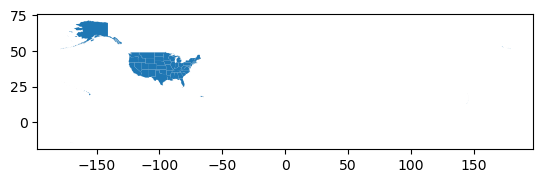

In [10]:
us_state_frames = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip")
us_state_frames.plot()

In [12]:
print(us_ufo_data["shape"].value_counts())

shape
light        14268
triangle      6952
circle        6650
fireball      5364
unknown       5077
other         4836
disk          4555
sphere        4529
oval          3260
formation     2112
cigar         1750
changing      1708
flash         1165
rectangle     1129
cylinder      1089
diamond       1006
chevron        843
teardrop       633
egg            632
cone           278
cross          214
delta            7
round            2
pyramid          1
flare            1
hexagon          1
crescent         1
changed          1
Name: count, dtype: int64


In [125]:
us_ufo_data["State"] = us_ufo_data["state"].apply(
    lambda x: x.upper()
)
us_ufo_data.drop("state", axis = "columns", inplace = True)

C:\Users\alden\AppData\Local\Temp\ipykernel_4616\682346838.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_ufo_data["State"] = us_ufo_data["state"].apply(
C:\Users\alden\AppData\Local\Temp\ipykernel_4616\682346838.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_ufo_data.drop("state", axis = "columns", inplace = True)


In [136]:
# Information for this function from: 
# https://medium.com/@alex_44314/use-python-geopandas-to-make-a-us-map-with-alaska-and-hawaii-39a9f5c222c6

# This function is fully copied from mediyum and it allows ranges of proportions to be matched to colors.
# Apply this to the gdf to ensure all states are assigned colors by the same func
def makeColorColumn(gdf,variable,vmin,vmax):
    # apply a function to a column to create a new column of assigned colors & return full frame
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.YlOrBr)
    gdf['value_determined_color'] = gdf[variable].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
    return gdf

def proportion_shape_frame(us_ufo_data, shape):
    # Count of states with shape found
    shape_data = us_ufo_data[us_ufo_data["shape"] == shape]
    state_counts = shape_data.groupby("State")["State"].size()

    # Counts made into DataFrame and percentages found
    temp_state_counts = pd.DataFrame()
    temp_state_counts["Shape Count"] = state_counts
    state_counts = temp_state_counts.reset_index()

    state_totals = us_ufo_data.groupby("State").size()
    temp_state_totals = pd.DataFrame()
    temp_state_totals["Total Reports"] = state_totals
    state_totals = temp_state_totals.reset_index()

    state_counts = state_counts.merge(right = state_totals, on = "State")

    state_counts["Shape Percentage"] = \
        state_counts["Shape Count"] / state_counts["Total Reports"] * 100

    shape_state_data = us_state_frames.copy()
    shape_state_data = shape_state_data.merge(right = state_counts, left_on = "STUSPS", right_on = "State")

    # For better proportions, crs instead of epsg will be used.
    shape_states_to_plot = shape_state_data.to_crs({'init':'epsg:2163'})

    # create figure and axes for with Matplotlib for main map
    fig, ax = plt.subplots(1, figsize=(18, 14))
    # remove the axis box from the main map
    ax.axis('off')
    ax.set_title(f'Percentage of UFO Sightings of the Description "{shape.capitalize()}" By State', fontdict={'fontsize': '42', 'fontweight' : '1'})
    ax.annotate("Code for Graph Largely Sourced From:\nhttps://medium.com/@alex_44314/use-python-geopandas-to-make-a-us-map-with-alaska-and-hawaii-39a9f5c222c6", xy=(0.22, .085), xycoords='figure fraction', fontsize=14, color='#555555')

    # This ensures that Hawaii and Alaska are not include in their original
    # positions. Instead they will be added later.
    shape_states_to_plot[~shape_states_to_plot.State.isin(['HI','AK'])].plot(color='lightblue', linewidth=0.8, ax=ax, edgecolor='0.8')

    vmin, vmax = (shape_states_to_plot["Shape Percentage"].min(), shape_states_to_plot["Shape Percentage"].max())
    colormap = "YlOrBr"
    shape_data_with_colors = makeColorColumn(shape_state_data, "Shape Percentage", vmin,vmax)

    # This code adds axes for the color key.
    cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])  
    cbax.set_title(f'Percentage of UFO sightings\nof the description "{shape}"\n')

    # This function converts data from number on 0 to 100 scale normalized to [0, 1]
    # interval to colors. This is used to actually add colors to key.
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

    # I am not fully sure what this does but it is somehow required to pass
    # a scalar mappaple to colorbar because it acts as a data parameter.
    sm._A = []

    # This lets you format the tick labels. It ensures that each tick
    # is formatted as a percentage.
    comma_fmt = FuncFormatter(lambda x, p: format(x/100, '.000%'))
    fig.colorbar(sm, cax=cbax, format=comma_fmt)
    tick_font_size = 16
    cbax.tick_params(labelsize=tick_font_size)

    # Method to plot each state one by one from website
    for row in shape_states_to_plot.itertuples():
        if row.State not in ['AK','HI']:
            # Info to plot state accessed.
            state_data = shape_states_to_plot[shape_state_data.State==row.State]

            # State color found
            color = shape_data_with_colors[shape_data_with_colors.State==row.State][0:1].value_determined_color.item()

            # State plotted with color
            state_data.plot(color=color, linewidth=0.8, ax=ax, edgecolor='0.8')

    # Almost all of this code also comes from the website above. It adds Hawaii and Alaska.
    # add Alaska
    # This axis is where in the whole plot alaska will be added.
    akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
    akax.axis('off')
    # This polygon cuts out Alaska from the whole map so that it can be added into new map.
    polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])

    # Alaska color data found the same was as other states.
    alaska_data = shape_data_with_colors[shape_data_with_colors.State=='AK']
    alaska_data.clip(polygon).plot(color=shape_data_with_colors[shape_data_with_colors.State=='AK'].value_determined_color, linewidth=0.8,ax=akax, edgecolor='0.8')


    # add Hawaii
    # This axis is where Hawaii will be added.
    hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
    hiax.axis("off")
    # This cuts Hawaii out form overall map
    hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
    hawaii_data = shape_data_with_colors[shape_data_with_colors.State=='HI']
    hawaii_data.clip(hipolygon).plot(color=shape_data_with_colors[shape_data_with_colors.State=="HI"].value_determined_color, linewidth=0.8,ax=hiax, edgecolor='0.8')

    return fig

c:\Users\alden\anaconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


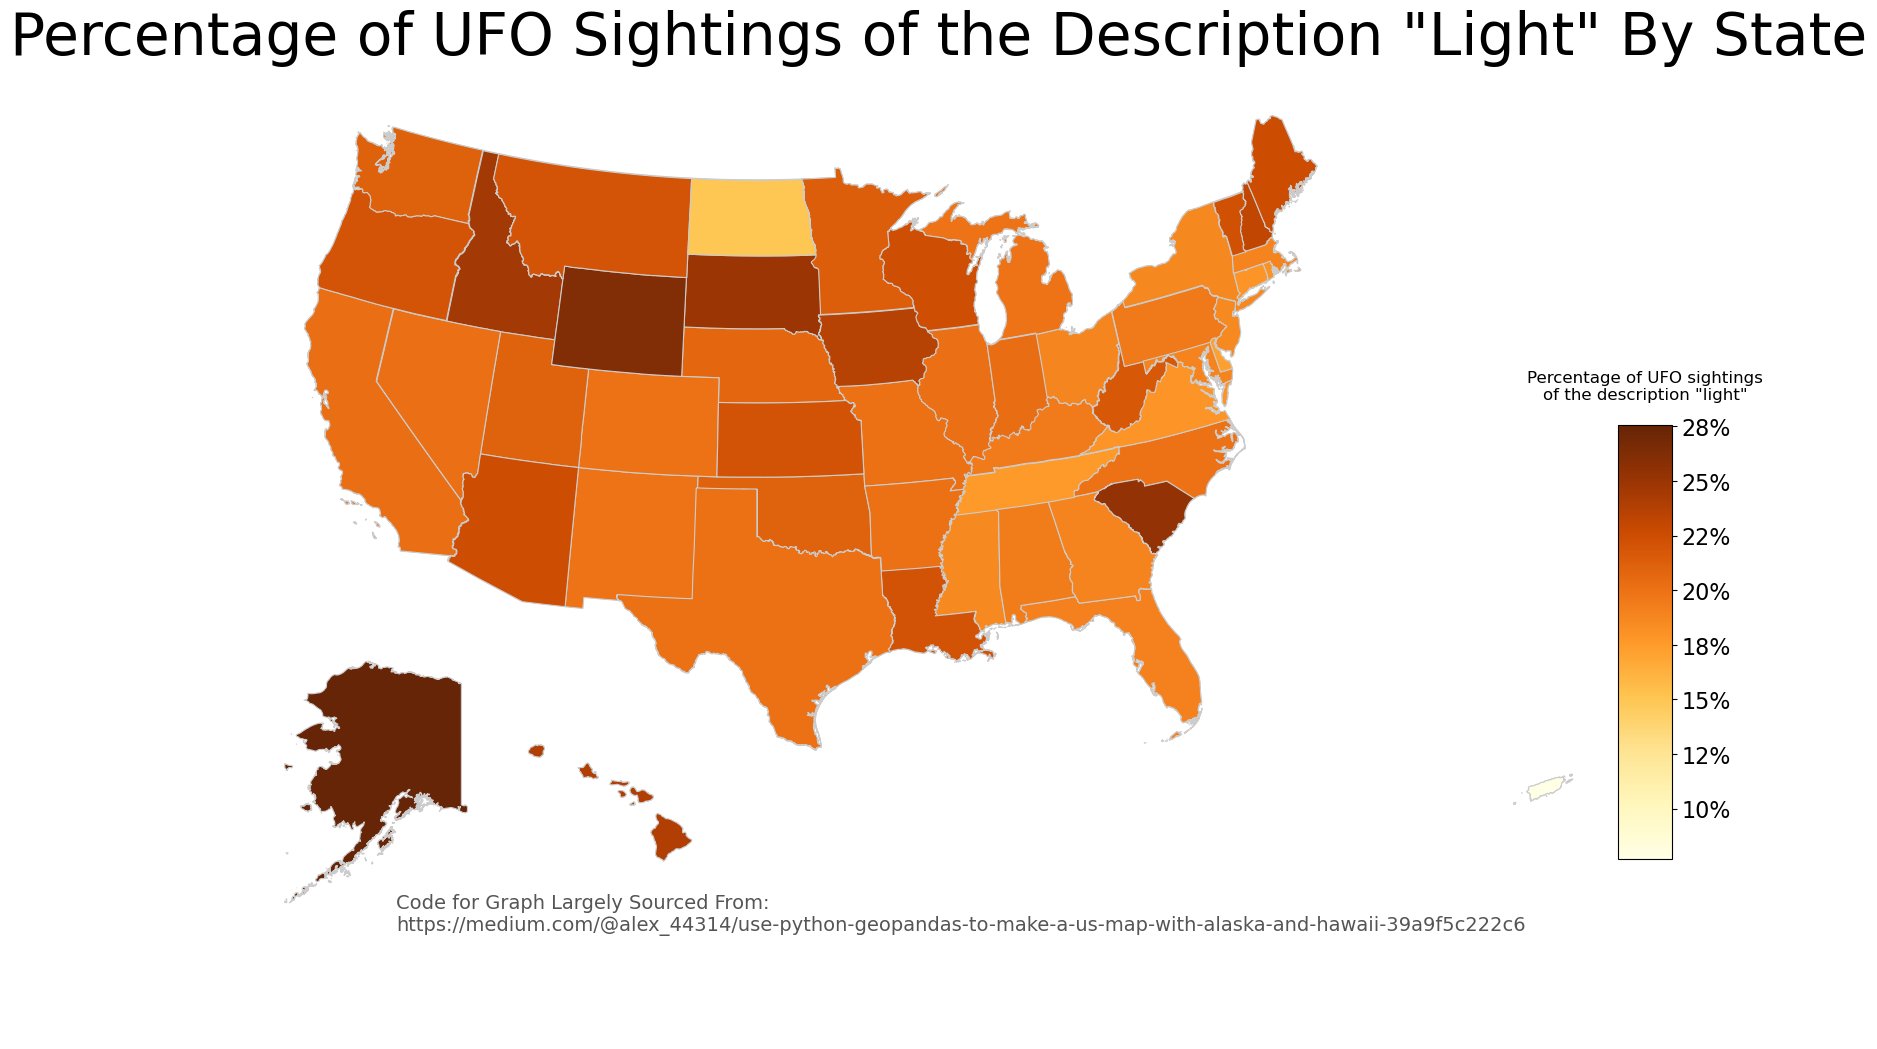

c:\Users\alden\anaconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


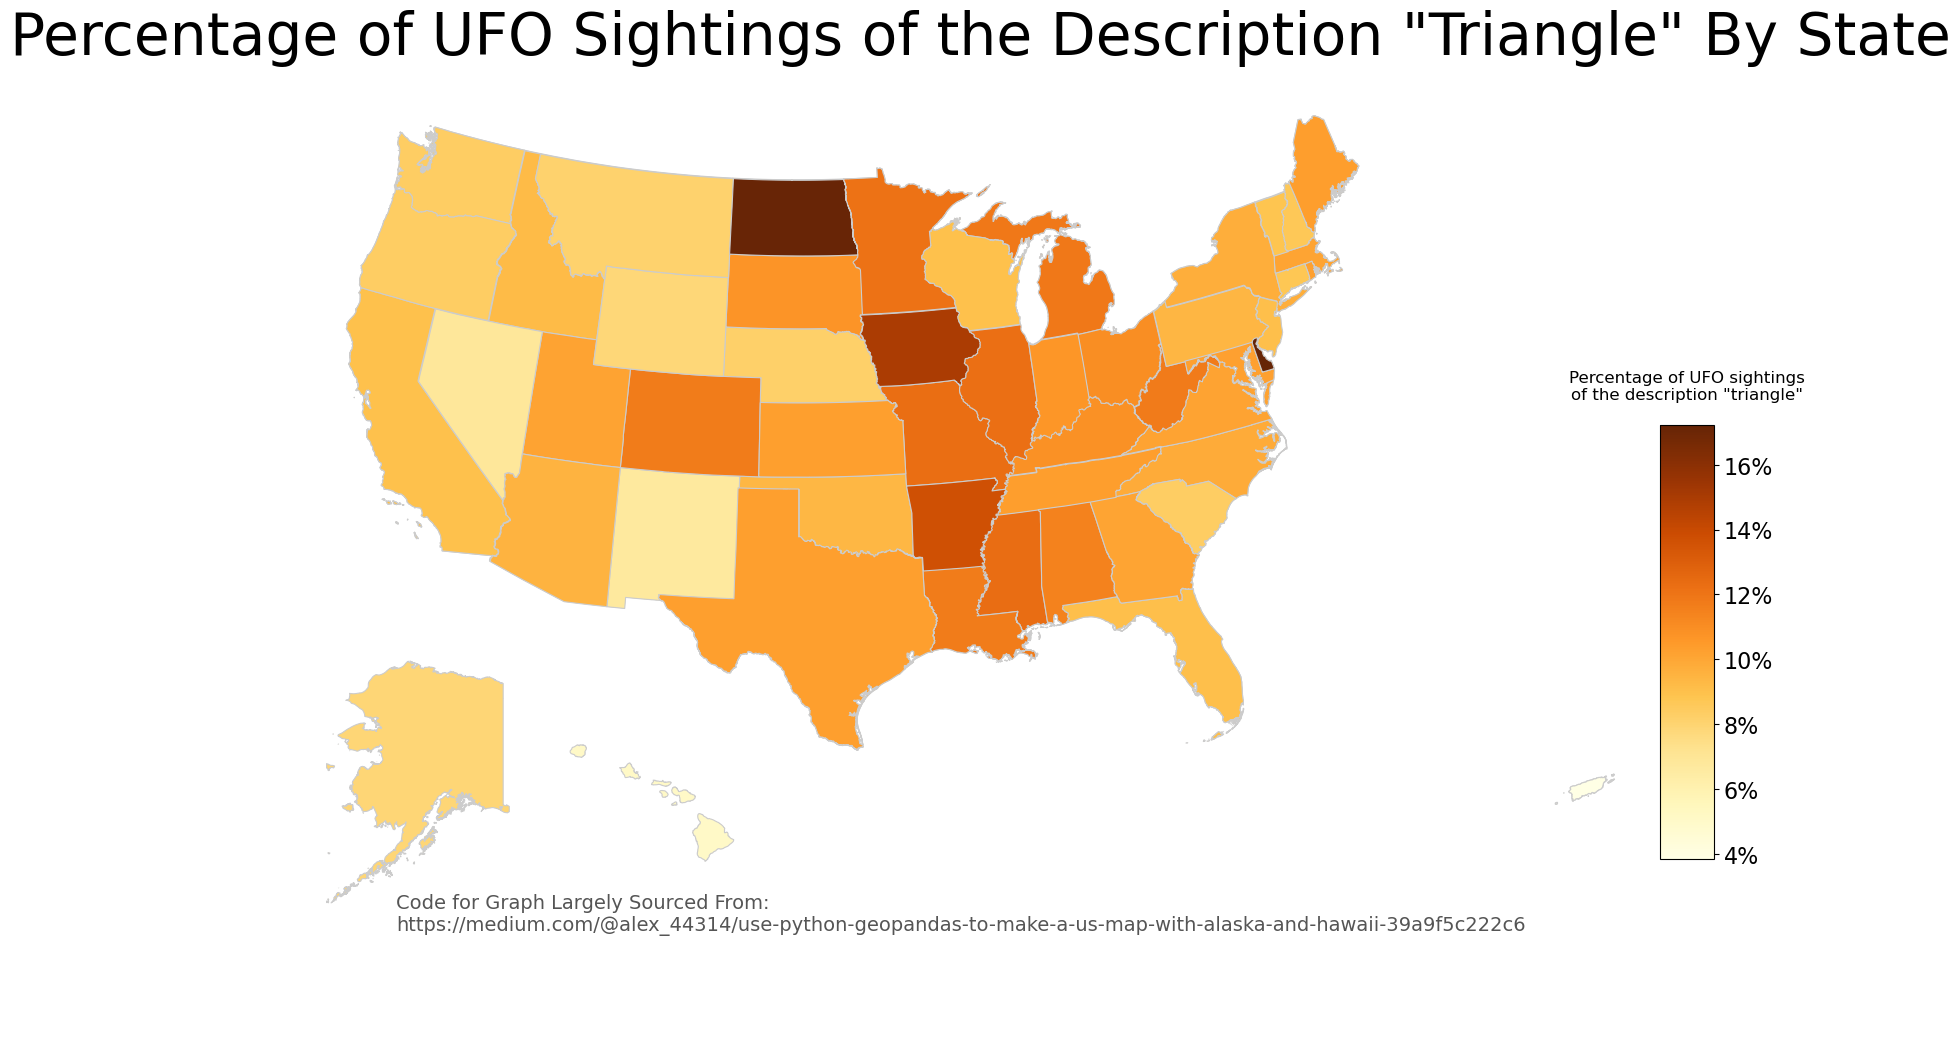

c:\Users\alden\anaconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


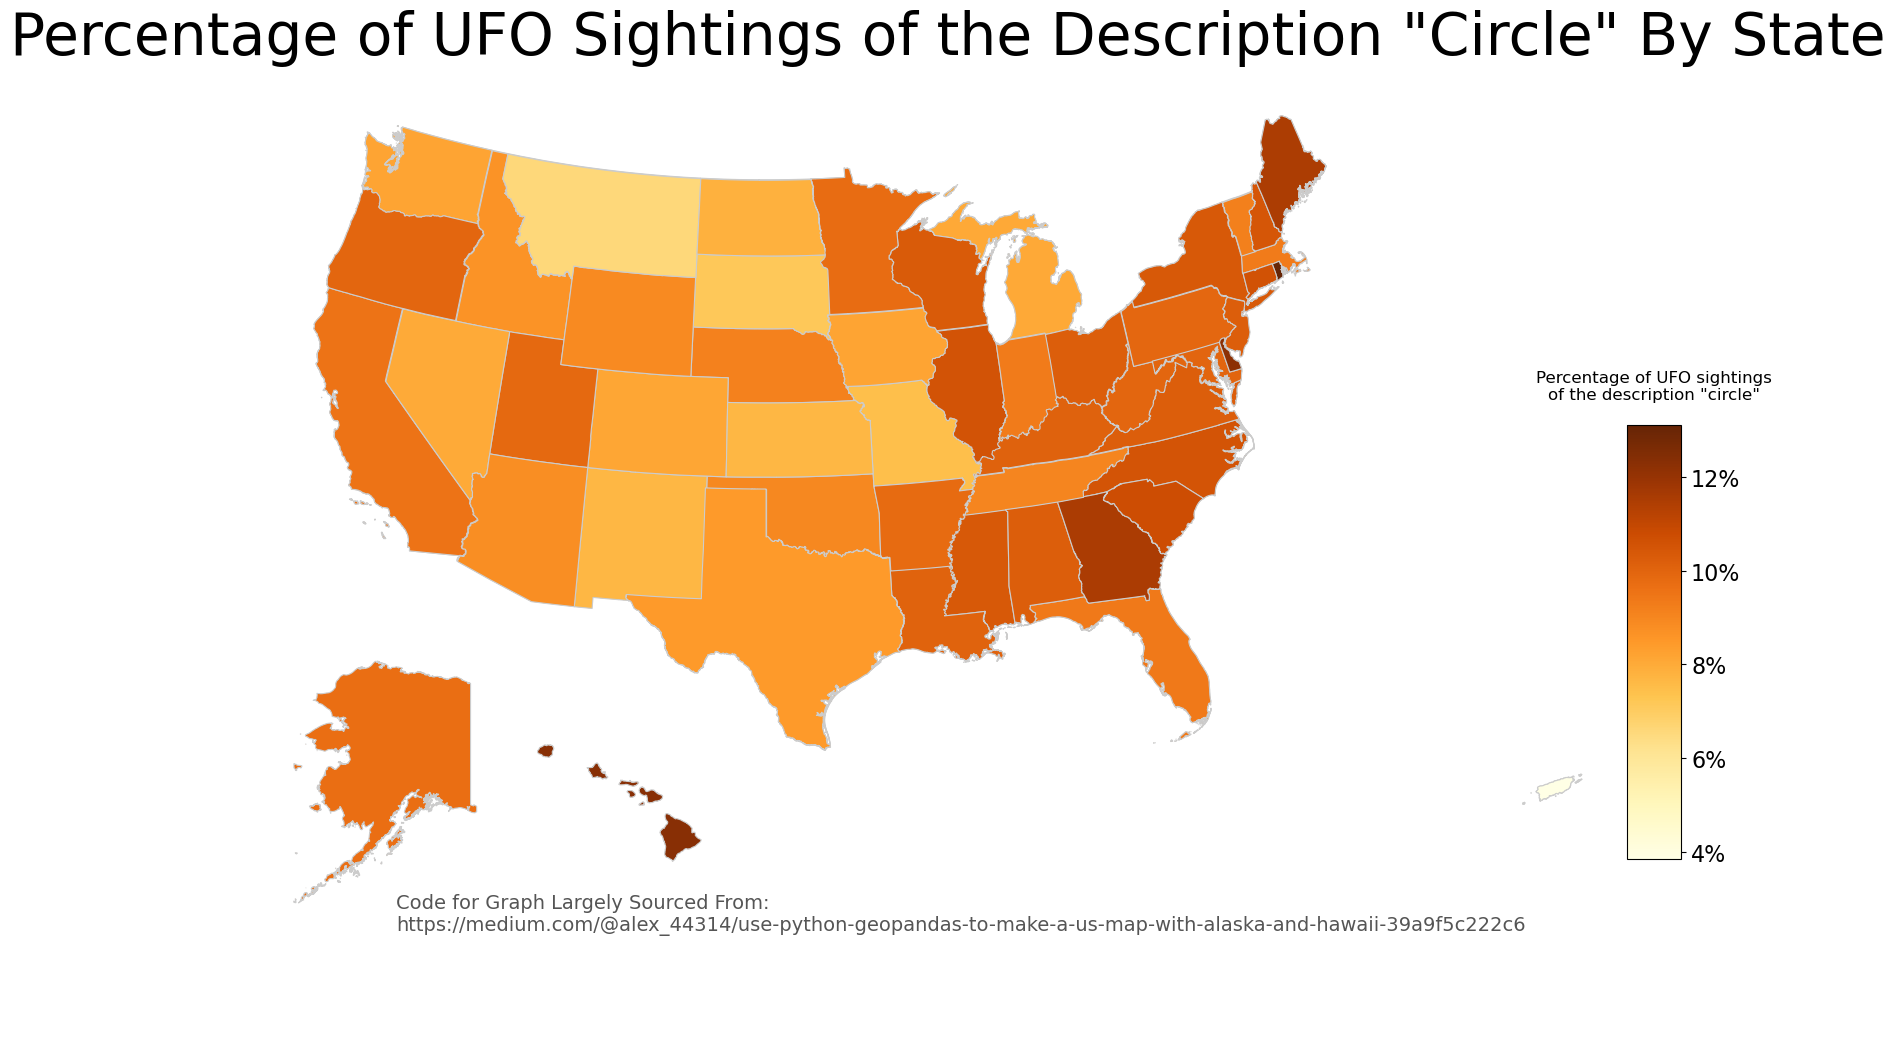

c:\Users\alden\anaconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


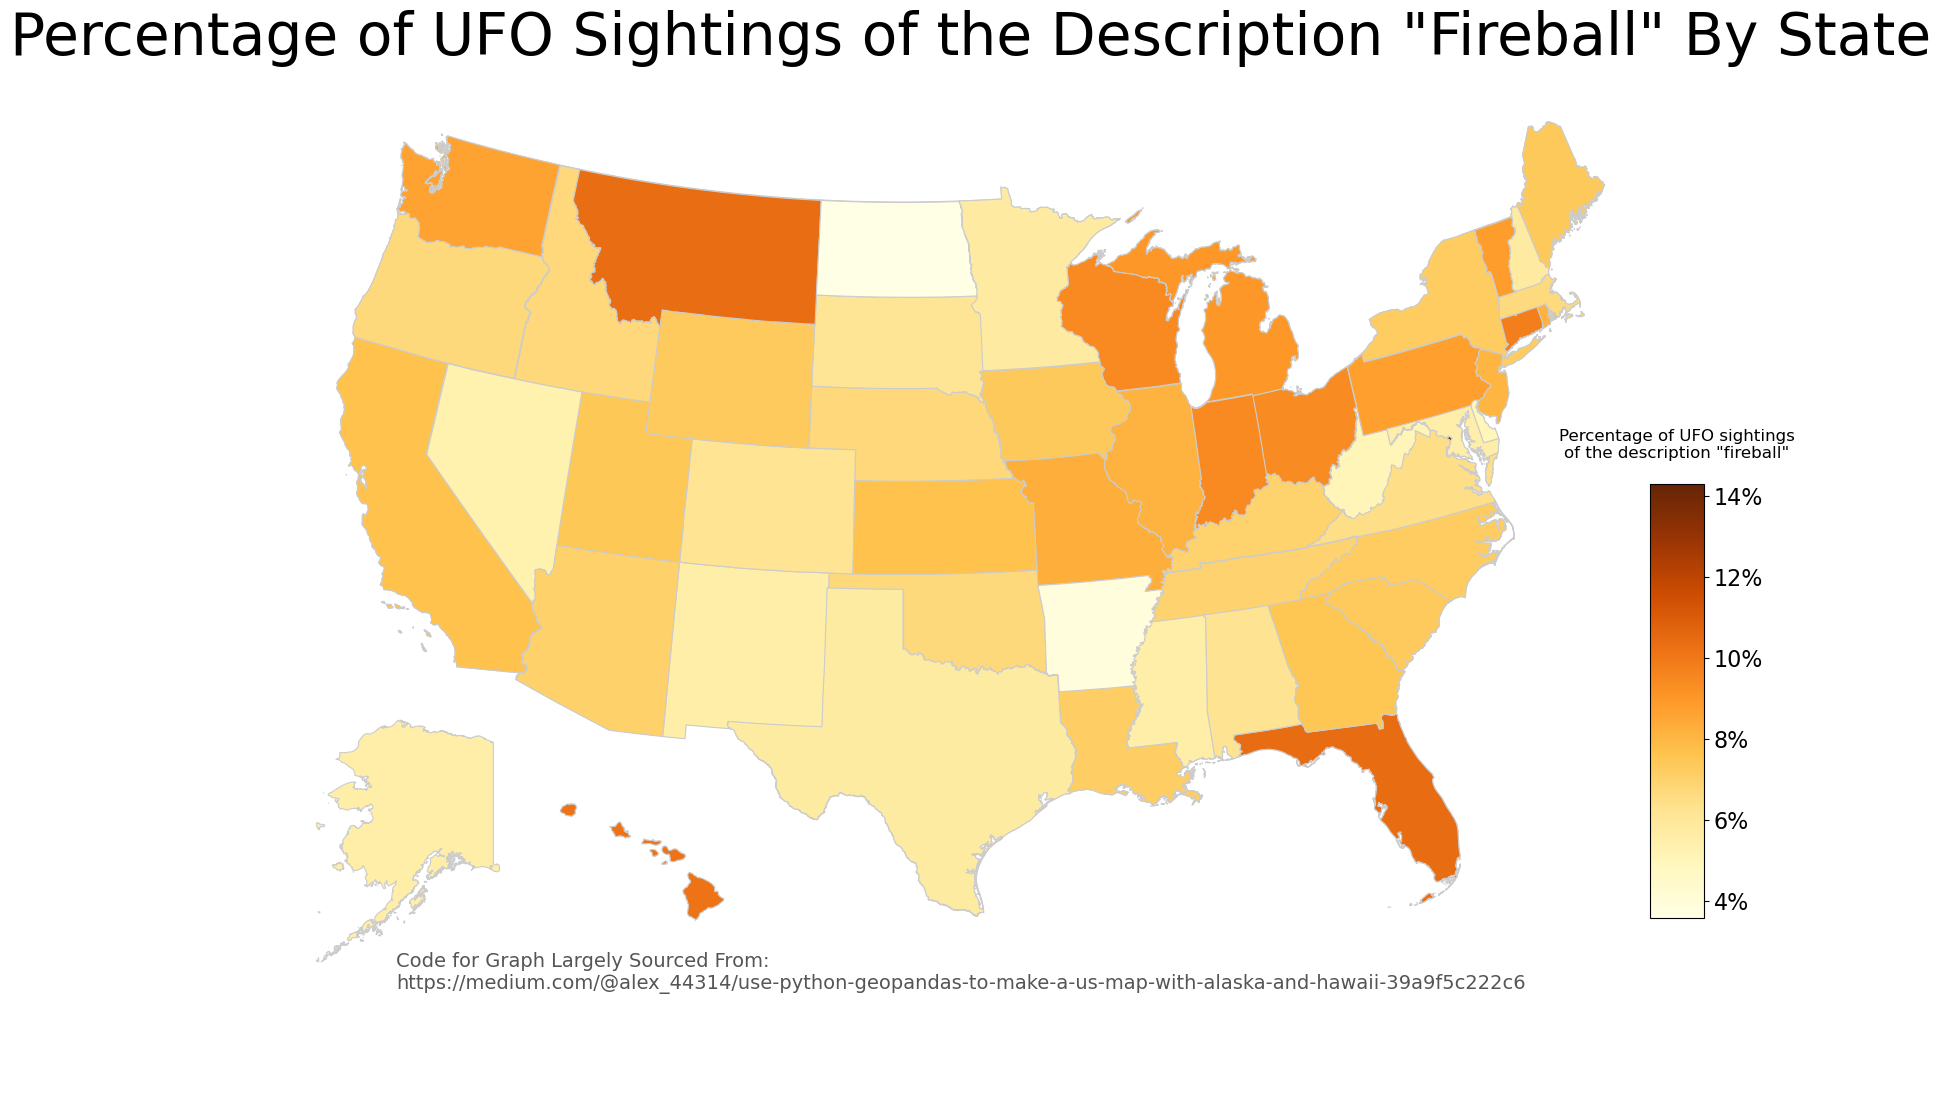

c:\Users\alden\anaconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


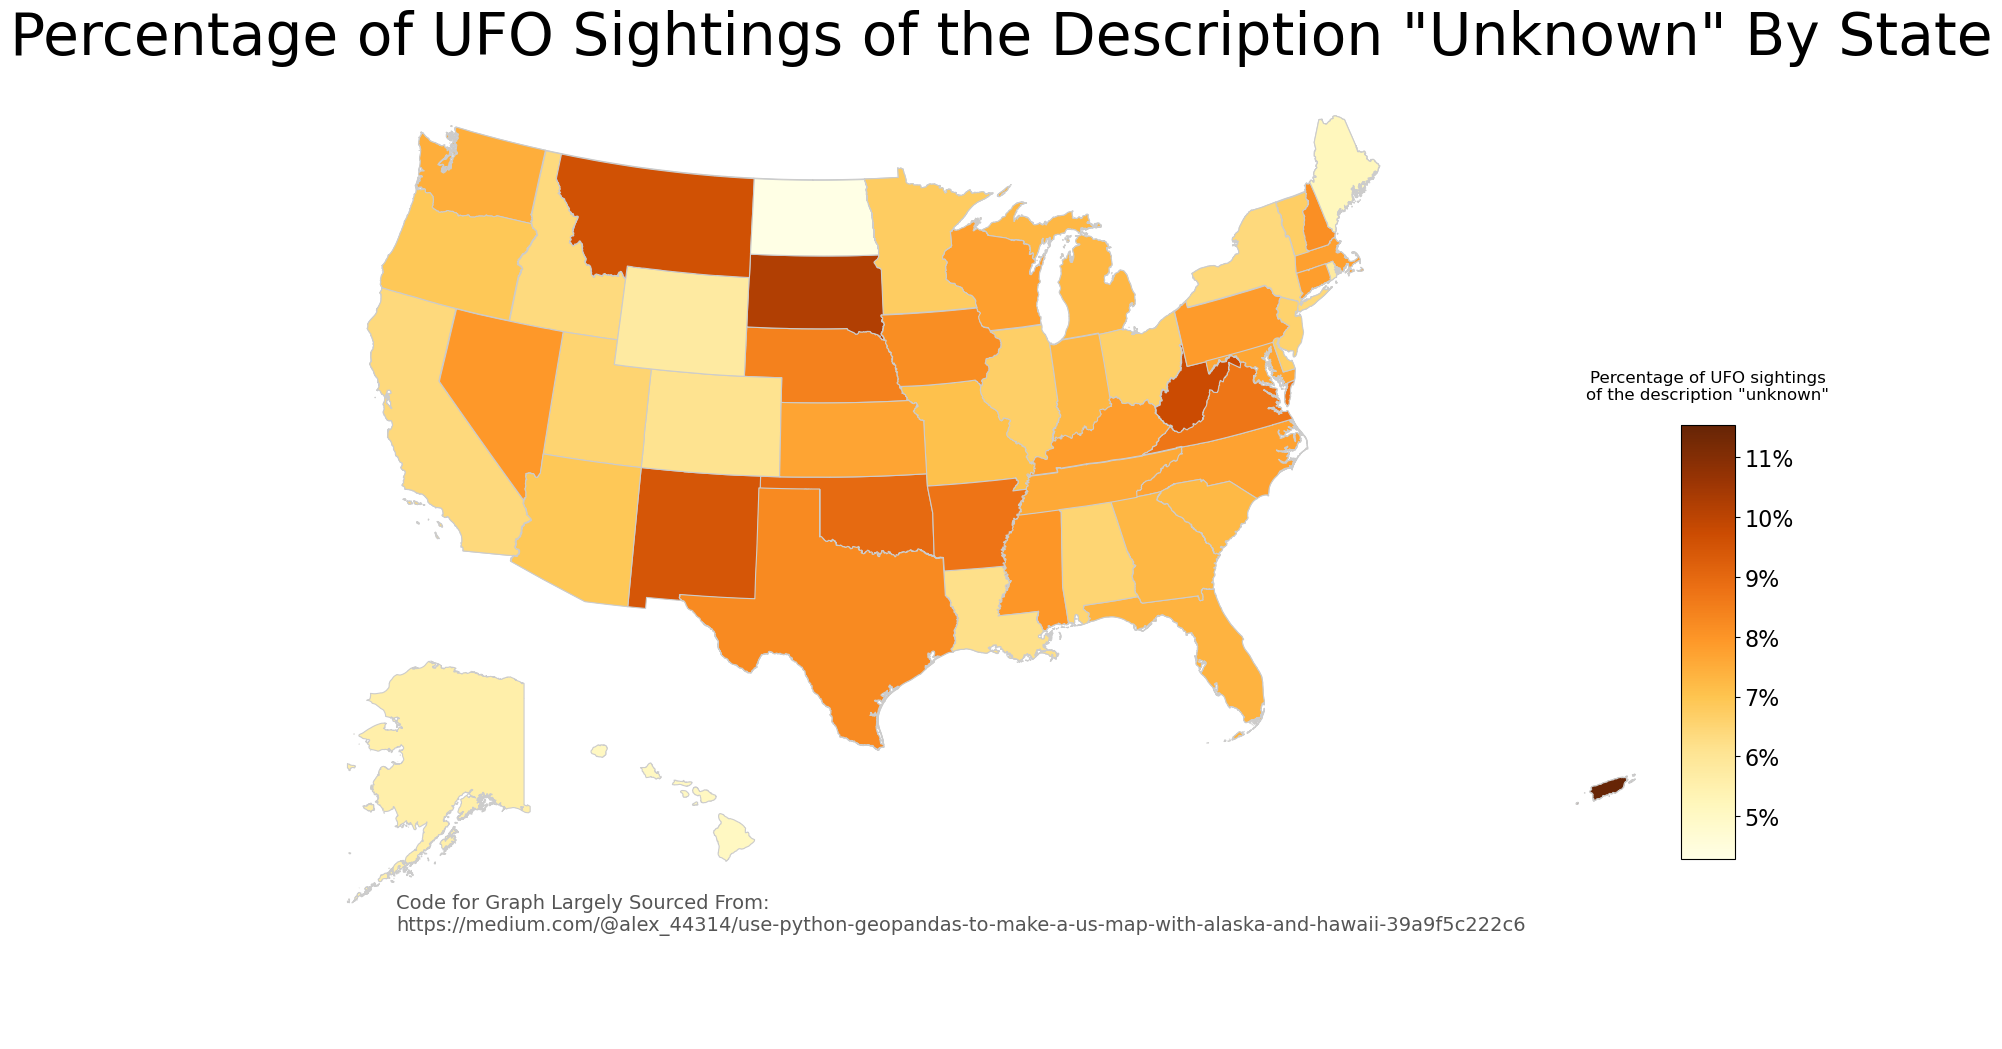

c:\Users\alden\anaconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


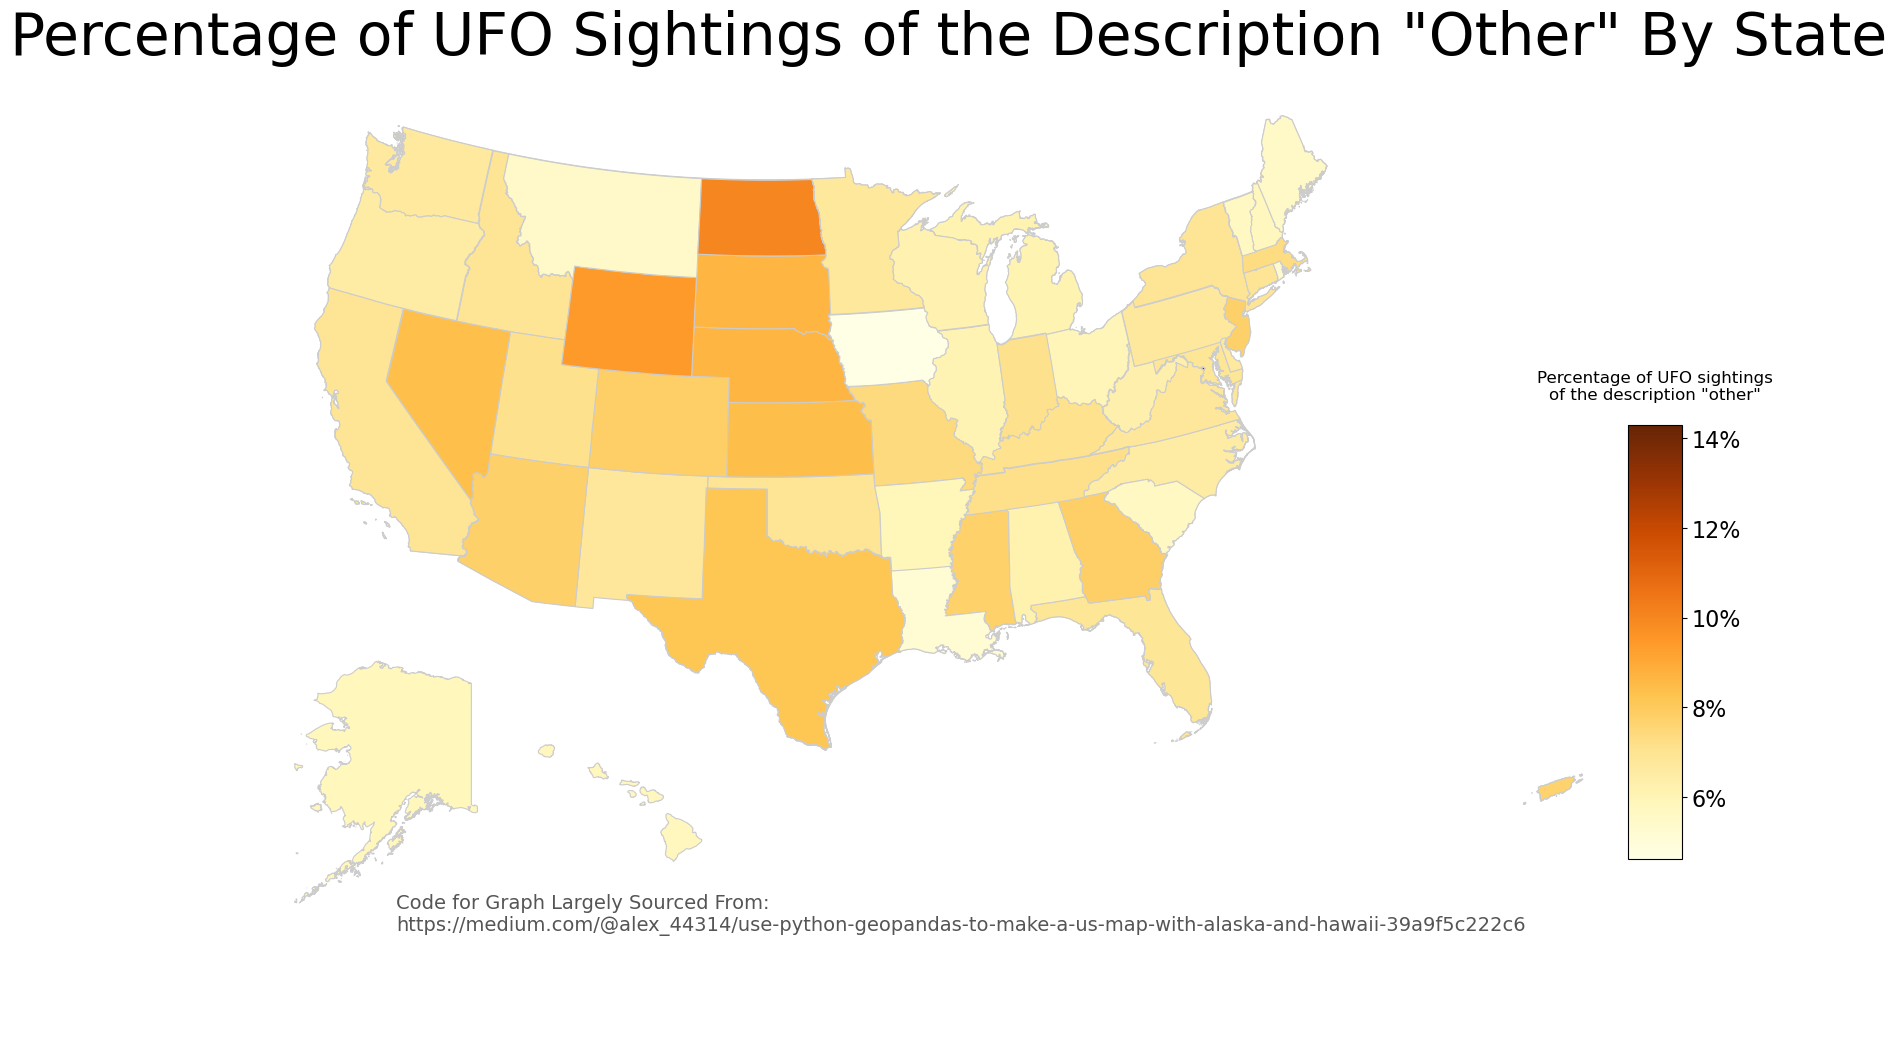

c:\Users\alden\anaconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


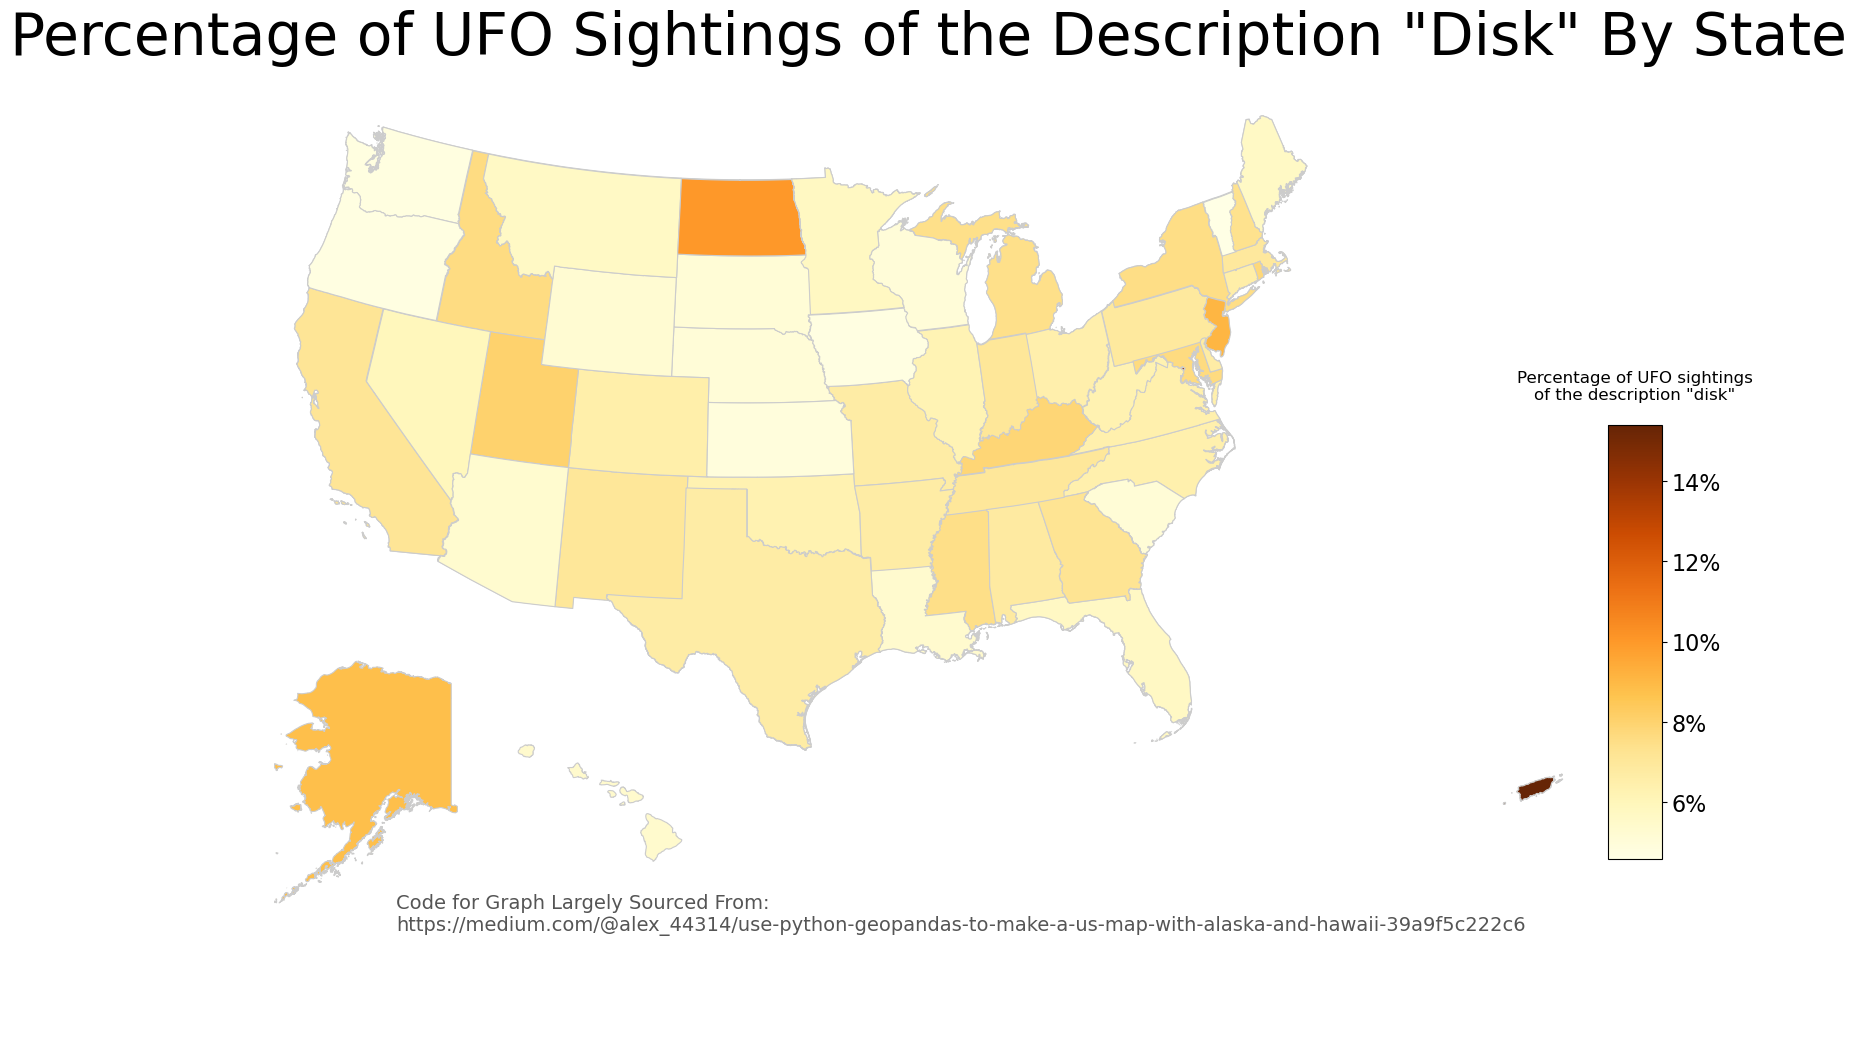

c:\Users\alden\anaconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


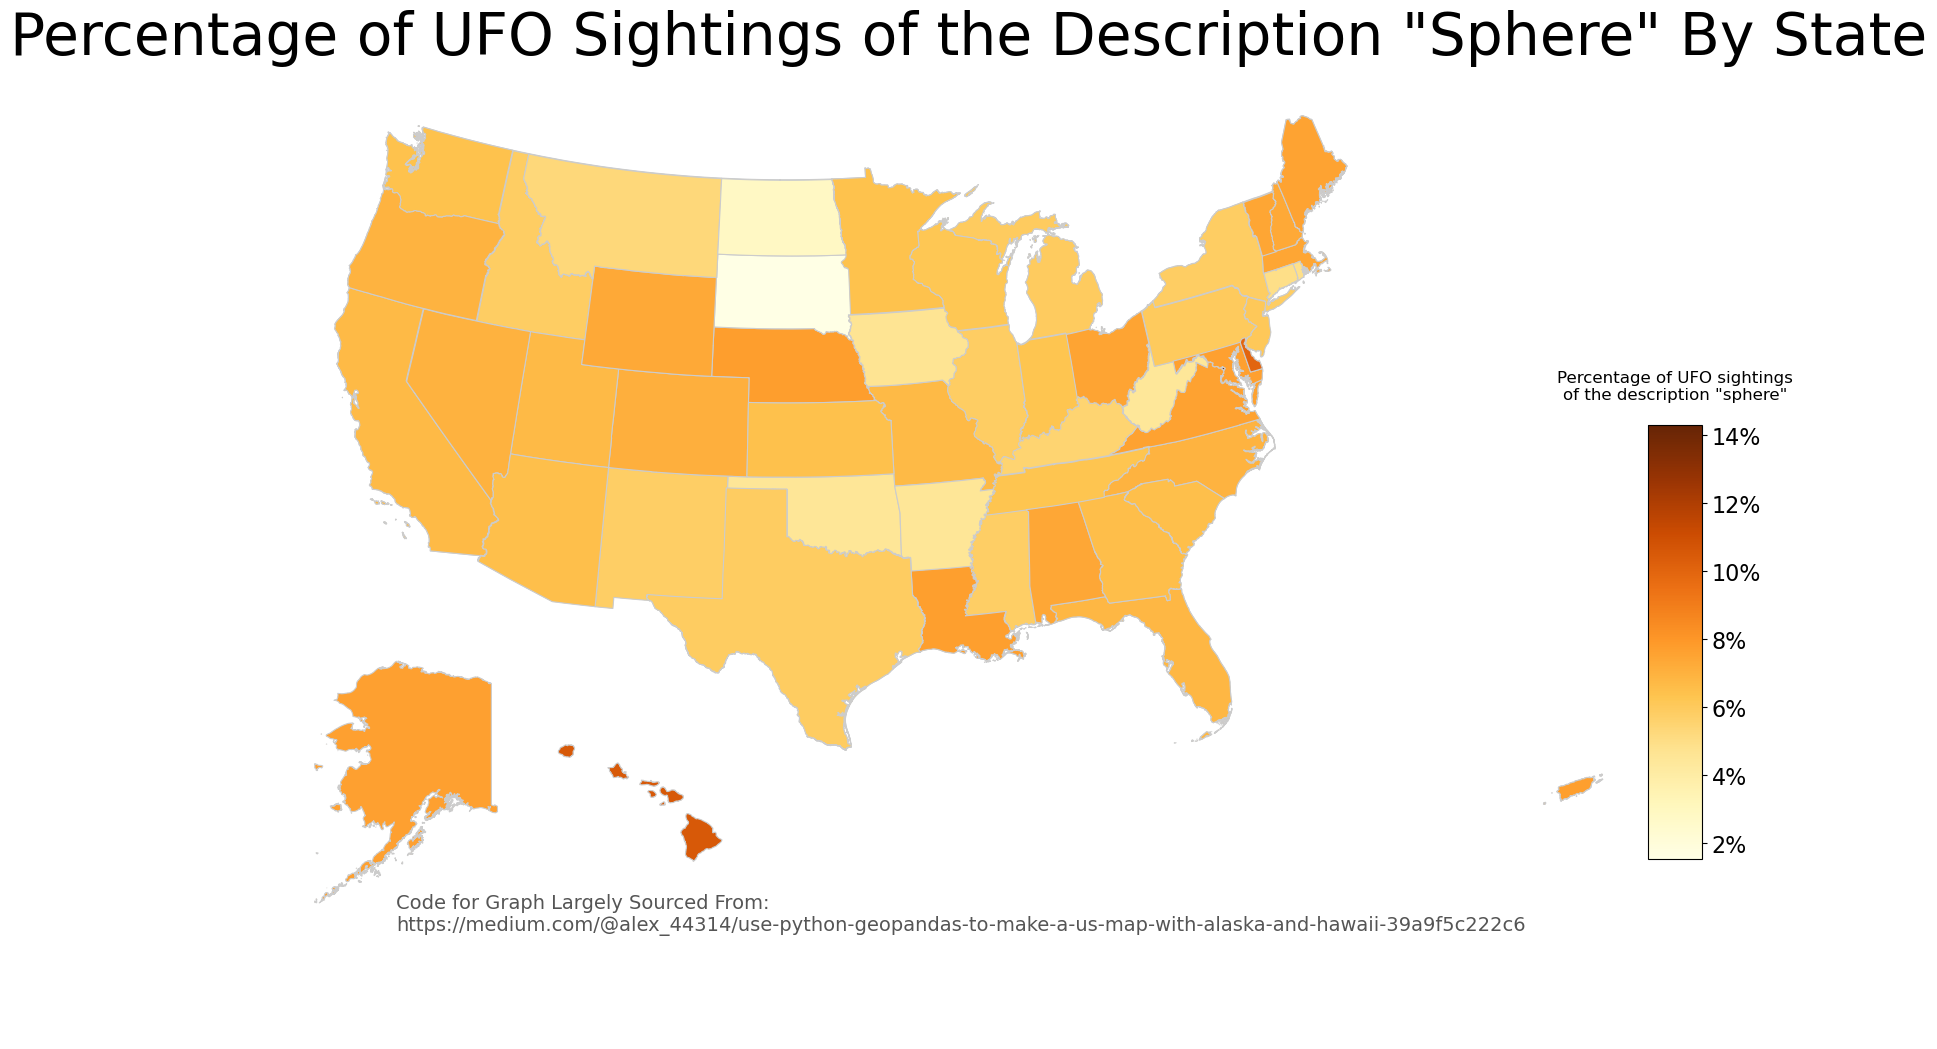

c:\Users\alden\anaconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


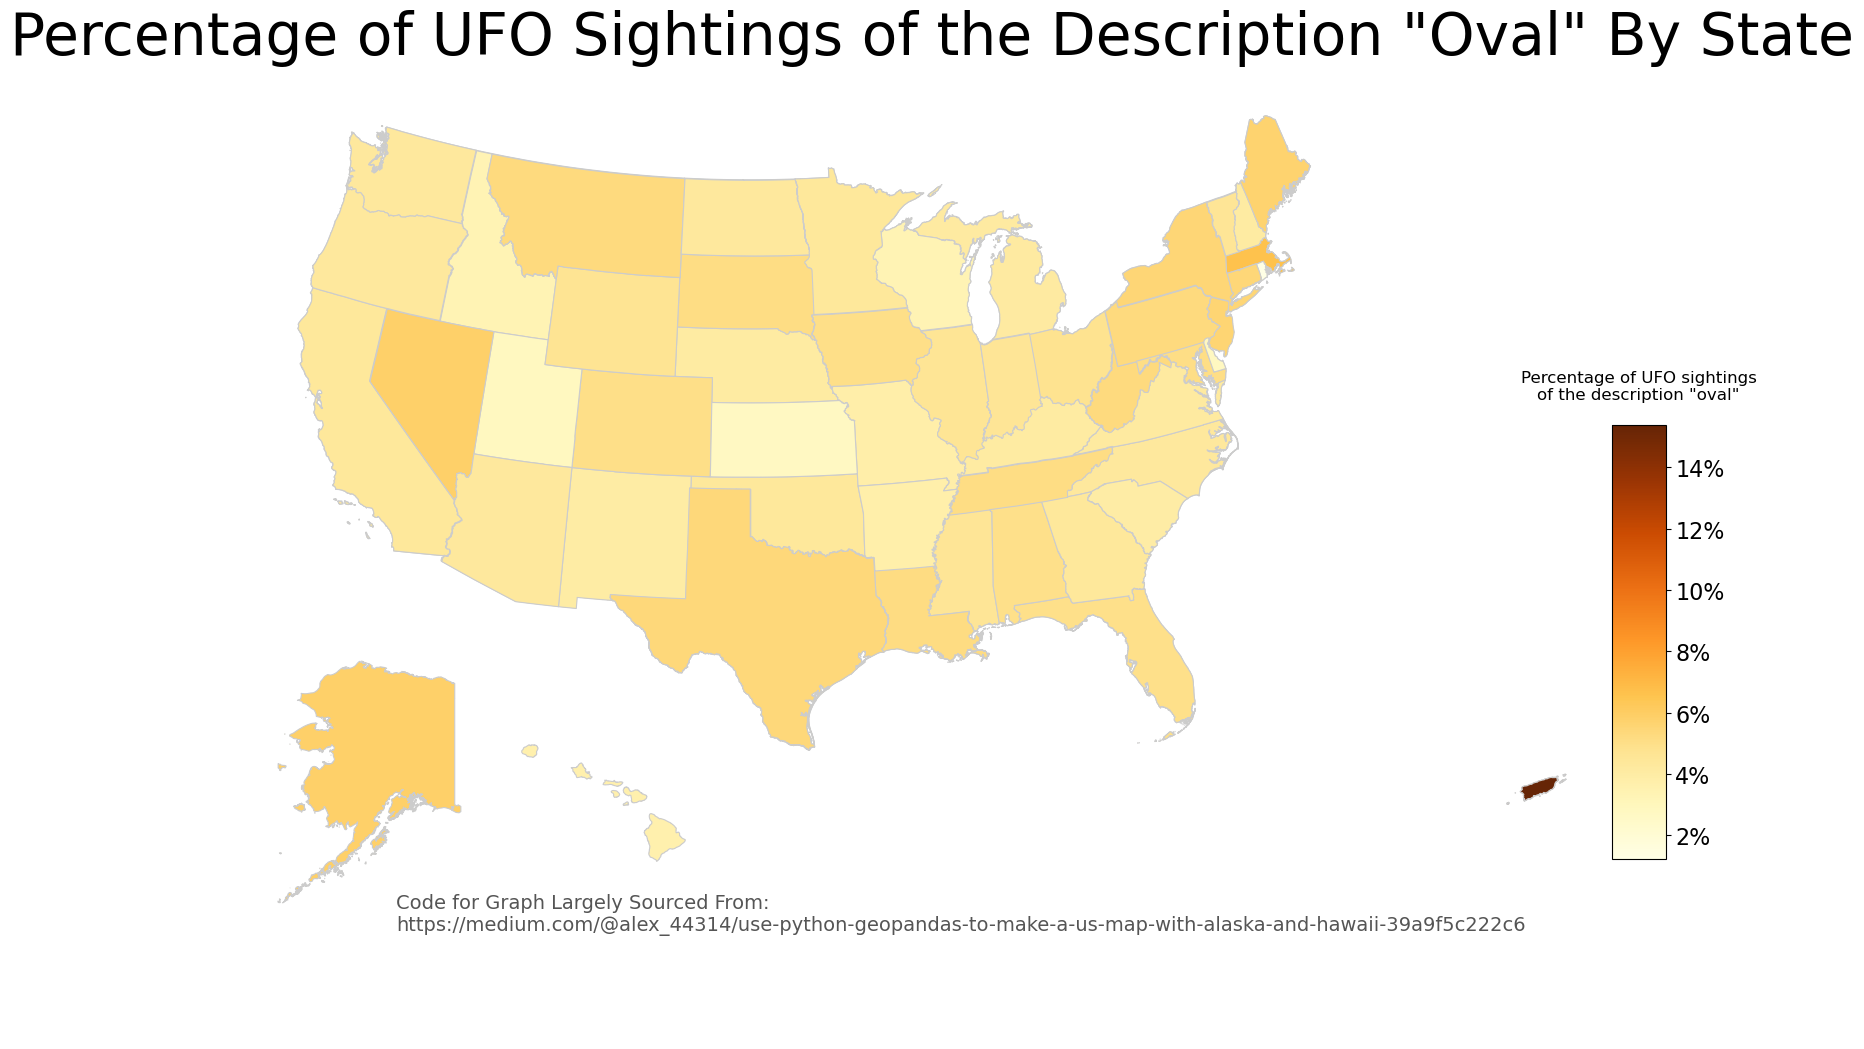

c:\Users\alden\anaconda3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


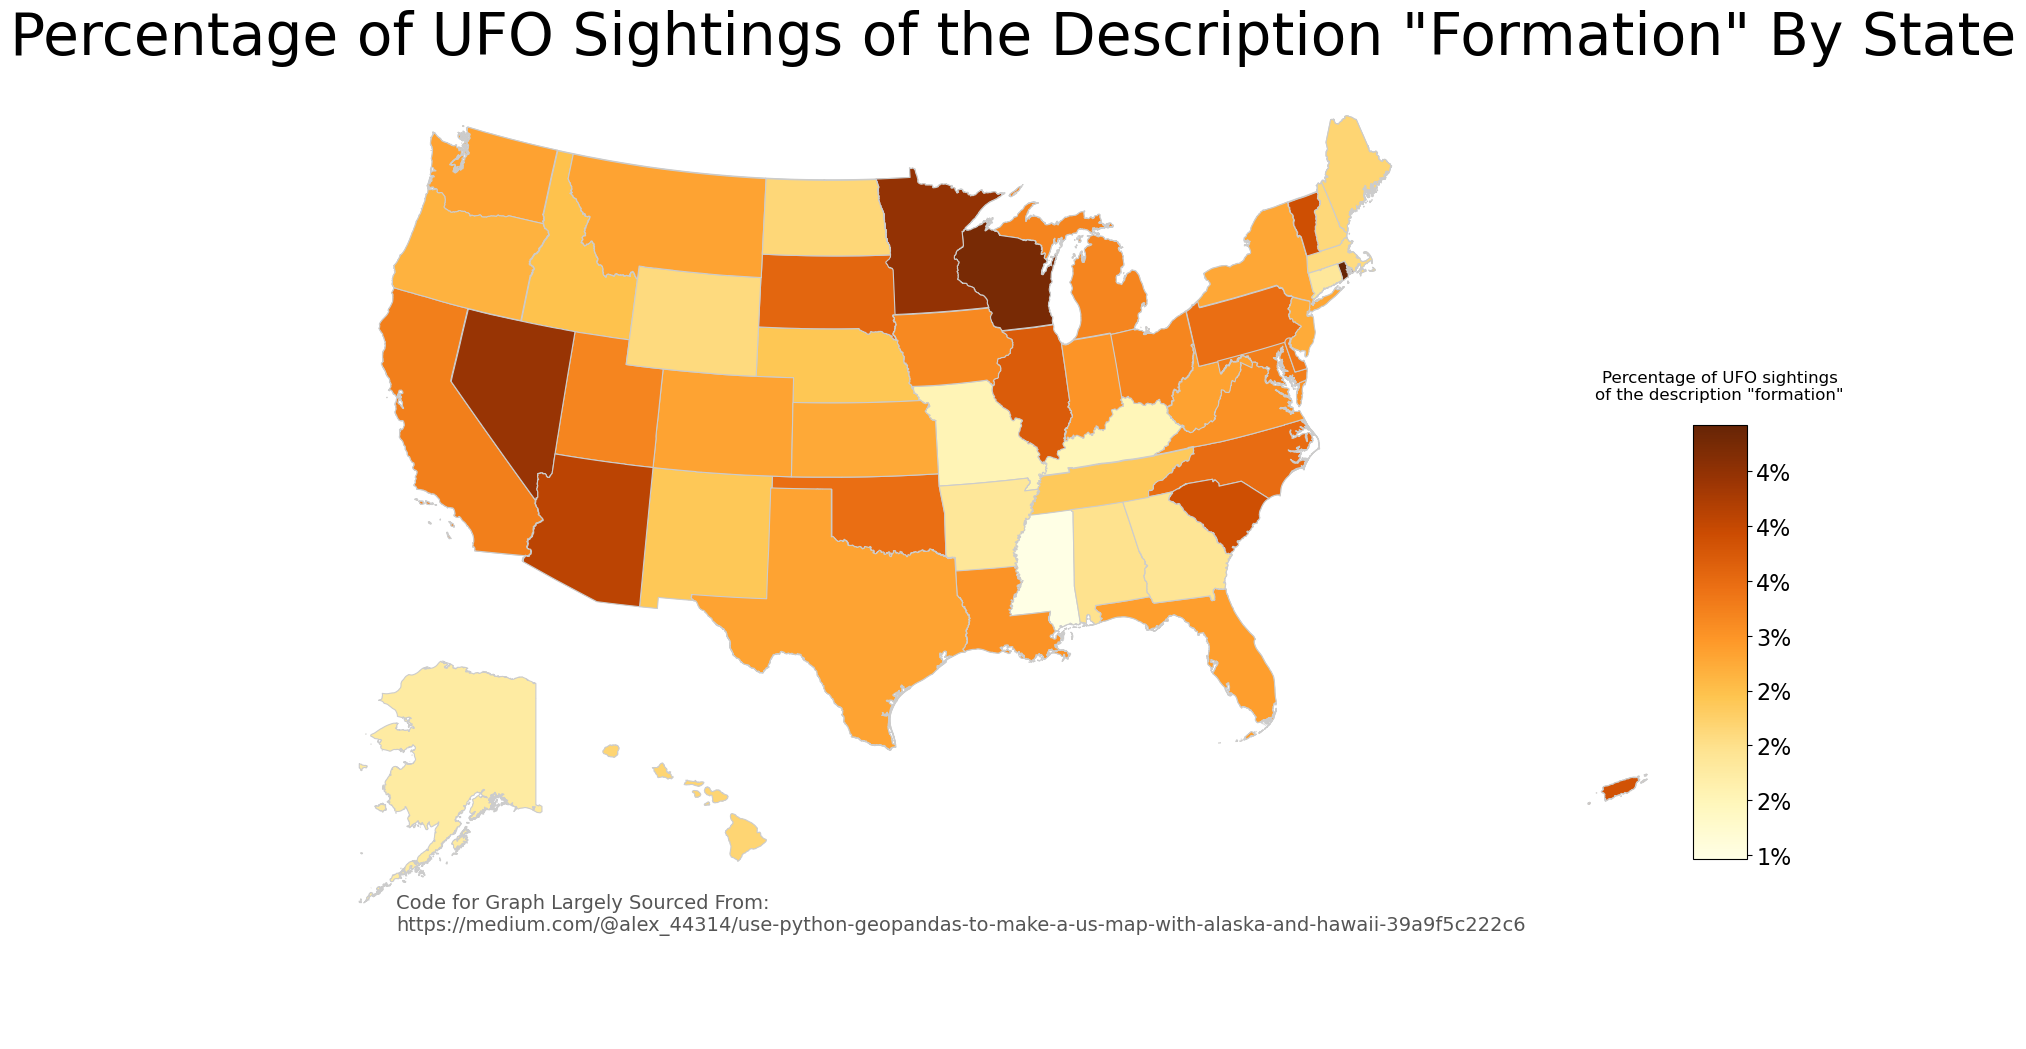

In [137]:
all_shapes = us_ufo_data["shape"].value_counts()
# Plots maps for top ten shapes
for i in range(10):
    proportion_shape_frame(us_ufo_data = us_ufo_data, shape = list(all_shapes.index)[i])
    plt.show()